In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
from tensorflow import math as tfm
#import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
#import cartopy.crs as ccrs
import matplotlib.ticker as mticker
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
import sklearn
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from cbrain.imports import *
from cbrain.utils import *
from cbrain.normalization import *
import h5py
from sklearn.preprocessing import OneHotEncoder
from cbrain.climate_invariant import *
import yaml
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Load coordinates (just pick any file from the climate model run)
coor = xr.open_dataset("/DFS-L/DATA/pritchard/ankitesg/data/CESM2_f19_v13_updated_NN_pelayout01_ens_07.cam.h1.2003-01-22-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
DATA_DIR = '/DFS-L/DATA/pritchard/ankitesg/datav3/'
hyam = coor.hyam
hybm = coor.hybm
scale_dict = load_pickle('/export/nfs0home/ankitesg/tom/CBRAIN-CAM/nn_config/scale_dicts/2020_10_16_scale_dict_RG.pkl')['scale_dict_RG']

In [3]:
in_vars = ['QBP','TBP','CLDLIQBP','CLDICEBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['QBCTEND','TBCTEND','CLDLIQBCTEND', 'CLDICEBCTEND', 'NN2L_FLWDS', 'NN2L_PRECC', 
            'NN2L_PRECSC', 'NN2L_SOLL', 'NN2L_SOLLD', 'NN2L_SOLS', 'NN2L_SOLSD', 'NN2L_NETSW']

In [4]:
TRAINFILE = 'RG_SP_M4K_train_shuffle.nc'
NORMFILE = 'RG_SP_M4K_NORM_norm.nc'
VALIDFILE = 'RG_SP_M4K_valid.nc'

In [5]:
train_gen_bf = DataGeneratorClimInvRealGeo(
    data_fn = f'{DATA_DIR}{TRAINFILE}',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = f'{DATA_DIR}{NORMFILE}',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=10000,
    shuffle=True,
    normalize_flag=True,
    lev=lev,
    hyam=hyam,hybm=hybm,
    rh_trans = False,t2tns_trans=False,
    lhflx_trans=False,
    scaling=False,
    interpolate=False
)


In [6]:
LIQ_ind = np.arange(52,78)
ICE_ind = np.arange(78,104)
QBC_ind = np.arange(0,26)
TBC_ind = np.arange(26,52)

In [17]:
LIQ = train_gen_bf[0][1][:,LIQ_ind]
ICE = train_gen_bf[0][1][:,ICE_ind]
QBC = train_gen_bf[0][1][:,QBC_ind]
TBC = train_gen_bf[0][1][:,TBC_ind]

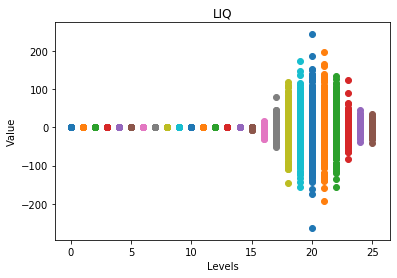

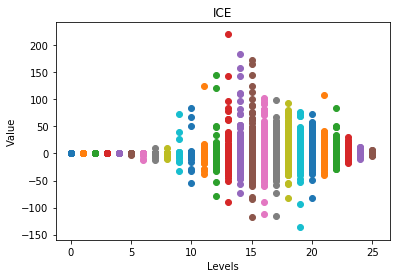

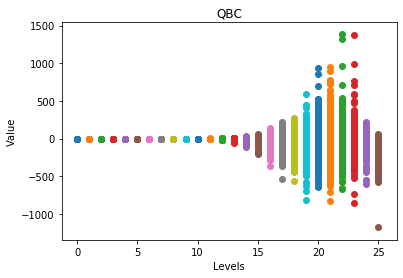

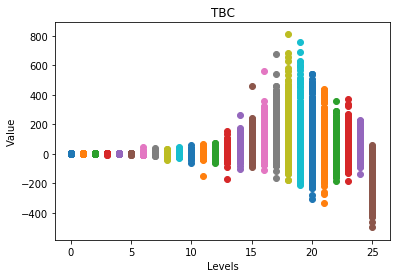

In [18]:
for i in range(0,26):
    plt.scatter([i]*10000,LIQ[:,i])
    plt.xlabel("Levels")
    plt.ylabel("Value")
    plt.title("LIQ")

plt.show()

for i in range(0,26):
    plt.scatter([i]*10000,ICE[:,i])
    plt.xlabel("Levels")
    plt.ylabel("Value")
    plt.title("ICE")
    
plt.show()

for i in range(0,26):
    plt.scatter([i]*10000,QBC[:,i])
    plt.xlabel("Levels")
    plt.ylabel("Value")
    plt.title("QBC")

plt.show()

for i in range(0,26):
    plt.scatter([i]*10000,TBC[:,i])
    plt.xlabel("Levels")
    plt.ylabel("Value")
    plt.title("TBC")
plt.show()

**What the model predicts**

In [19]:
model = Sequential()
model.add(Input(shape=(108,)))
model.add(Dense(units=320)
)
model.add(LeakyReLU(alpha=0.3))
for i in range (4):
    model.add(Dense(units=320))
    model.add(LeakyReLU(alpha=0.3))

model.add(Dense(112, activation='linear'))

In [20]:
path_HDF5 = '/DFS-L/DATA/pritchard/ankitesg/models/'
model.load_weights(path_HDF5+'BF_RGV11.h5')

In [21]:
predicted_normalized = model.predict(train_gen_bf[0][0])

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [22]:
LIQ_P = predicted_normalized[:,LIQ_ind]
ICE_P = predicted_normalized[:,ICE_ind]
QBC_P = predicted_normalized[:,QBC_ind]
TBC_P = predicted_normalized[:,TBC_ind]

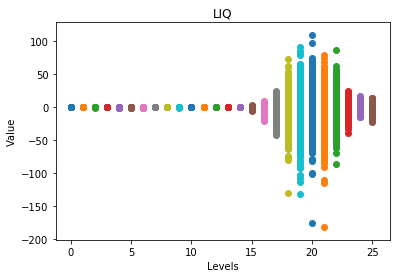

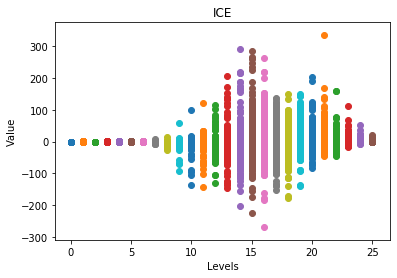

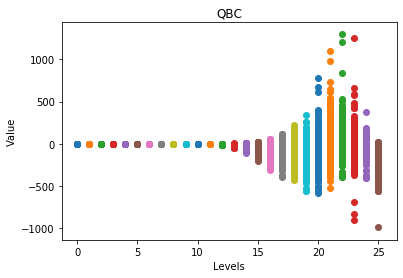

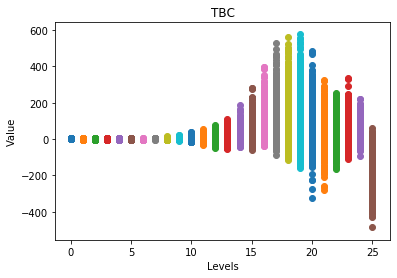

In [23]:
for i in range(0,26):
    plt.scatter([i]*10000,LIQ_P[:,i])
    plt.xlabel("Levels")
    plt.ylabel("Value")
    plt.title("LIQ")

plt.show()

for i in range(0,26):
    plt.scatter([i]*10000,ICE_P[:,i])
    plt.xlabel("Levels")
    plt.ylabel("Value")
    plt.title("ICE")
    
plt.show()

for i in range(0,26):
    plt.scatter([i]*10000,QBC_P[:,i])
    plt.xlabel("Levels")
    plt.ylabel("Value")
    plt.title("QBC")

plt.show()

for i in range(0,26):
    plt.scatter([i]*10000,TBC_P[:,i])
    plt.xlabel("Levels")
    plt.ylabel("Value")
    plt.title("TBC")
plt.show()

Observation: The pattern that the network predicts is similar, the magnitude seems to be predicted is changing, I suspect it is due to outlier

**Try this**: Remove outliers from the dataset and then train the model again

### Removing outliers 

Following the z-score method we remove outliers

In [12]:
ds = xr.open_dataset(f"{DATA_DIR}/{TRAINFILE}")
norm_ds = xr.open_dataset(f"{DATA_DIR}/{NORMFILE}")

In [121]:
mean_QBC = (train_gen_bf.norm_ds['mean'][return_var_idxs(train_gen_bf.norm_ds,['QBCTEND'])]*scale_dict['QBCTEND']).values
std_QBC = (train_gen_bf.norm_ds['std'][return_var_idxs(train_gen_bf.norm_ds,['QBCTEND'])]*scale_dict['QBCTEND']).values

mean_TBC = (train_gen_bf.norm_ds['mean'][return_var_idxs(train_gen_bf.norm_ds,['TBCTEND'])]*scale_dict['TBCTEND']).values
std_TBC = (train_gen_bf.norm_ds['std'][return_var_idxs(train_gen_bf.norm_ds,['TBCTEND'])]*scale_dict['TBCTEND']).values

mean_LIQ = (train_gen_bf.norm_ds['mean'][return_var_idxs(train_gen_bf.norm_ds,['CLDLIQBCTEND'])]*scale_dict['CLDLIQBCTEND']).values
std_LIQ = (train_gen_bf.norm_ds['std'][return_var_idxs(train_gen_bf.norm_ds,['CLDLIQBCTEND'])]*scale_dict['CLDLIQBCTEND']).values

mean_ICE = (train_gen_bf.norm_ds['mean'][return_var_idxs(train_gen_bf.norm_ds,['CLDICEBCTEND'])]*scale_dict['CLDICEBCTEND']).values
std_ICE = (train_gen_bf.norm_ds['std'][return_var_idxs(train_gen_bf.norm_ds,['CLDICEBCTEND'])]*scale_dict['CLDICEBCTEND']).values

In [135]:
z_score_qbc = (train_gen_bf[0][1][:,range(0,26)] - mean_QBC)/(std_QBC+1e-8)
z_score_tbc = (train_gen_bf[0][1][:,range(26,52)] - mean_TBC)/(std_TBC+1e-8)
z_score_liq = (train_gen_bf[0][1][:,range(52,78)] - mean_LIQ)/(std_LIQ+1e-8)
z_score_ice = (train_gen_bf[0][1][:,range(78,104)] - mean_ICE)/(std_ICE+1e-8)

In [136]:
cleand_zcore_qbc = z_score_qbc[((abs(z_score_qbc)<3).sum(axis=1) == 26)]
cleand_zcore_tbc = z_score_tbc[((abs(z_score_tbc)<3).sum(axis=1) == 26)]
cleand_zcore_liq = z_score_liq[((abs(z_score_liq)<3).sum(axis=1) == 26)]
cleand_zcore_ice = z_score_ice[((abs(z_score_ice)<3).sum(axis=1) == 26)]

In [137]:
QBC_cleaned = (train_gen_bf[0][1][:,QBC_ind])[((abs(z_score_qbc)<3).sum(axis=1) == 26)]
TBC_cleaned = (train_gen_bf[0][1][:,TBC_ind])[((abs(z_score_tbc)<3).sum(axis=1) == 26)]
LIQ_cleaned = (train_gen_bf[0][1][:,LIQ_ind])[((abs(z_score_liq)<3).sum(axis=1) == 26)]
ICE_cleaned = (train_gen_bf[0][1][:,ICE_ind])[((abs(z_score_ice)<3).sum(axis=1) == 26)]

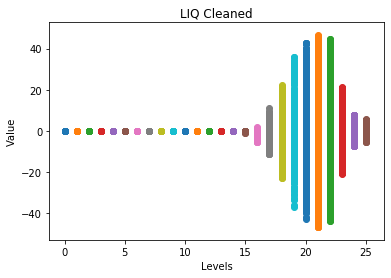

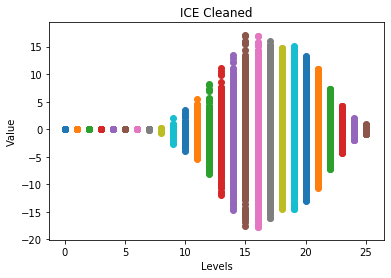

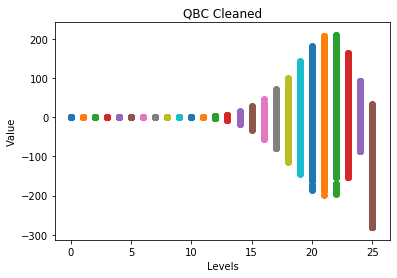

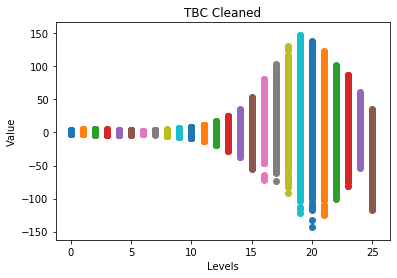

In [139]:
for i in range(0,26):
    plt.scatter([i]*LIQ_cleaned.shape[0],LIQ_cleaned[:,i])
    plt.xlabel("Levels")
    plt.ylabel("Value")
    plt.title("LIQ Cleaned")

plt.show()

for i in range(0,26):
    plt.scatter([i]*ICE_cleaned.shape[0],ICE_cleaned[:,i])
    plt.xlabel("Levels")
    plt.ylabel("Value")
    plt.title("ICE Cleaned")
    
plt.show()

for i in range(0,26):
    plt.scatter([i]*QBC_cleaned.shape[0],QBC_cleaned[:,i])
    plt.xlabel("Levels")
    plt.ylabel("Value")
    plt.title("QBC Cleaned")

plt.show()

for i in range(0,26):
    plt.scatter([i]*TBC_cleaned.shape[0],TBC_cleaned[:,i])
    plt.xlabel("Levels")
    plt.ylabel("Value")
    plt.title("TBC Cleaned")
plt.show()

Next steps: Train the model with removed outliers